In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import os
import math
from tqdm import tqdm

import src.utils as utils
from bimvee.importIitYarp import importIitYarp

In [2]:
## import data
# sequence_name = "button4"
# path = os.path.join("/home/schiavazza/data/hpe/fault_button/binary/long", sequence_name)
sequence_name = "s26_v2"
path = os.path.join("/home/schiavazza/data/hpe/fault_button/osai/fault_button", sequence_name)

try:
    events = importIitYarp(filePathOrName=path)
except Exception as e:
    print("could not import data")
    print(e)
    exit

importIitYarp trying path: /home/schiavazza/data/hpe/fault_button/osai/fault_button/s2_v2
Examining info.log: /home/schiavazza/data/hpe/fault_button/osai/fault_button/s2_v2/info.log


In [3]:
with open(path + "/positions.csv", newline='') as csvfile:
    positions = np.loadtxt(csvfile)
with open(path + "/timing_press.csv", newline='') as csvfile:
    press_timing = np.loadtxt(csvfile)

In [4]:
# the roi center is the button position
roi_center = [
    positions[0, [2, 4]].sum() / 2,
    positions[0, [1, 3]].sum() / 2
]
# the roi edge is manually selected close the the person
roi_edge = [
    positions[1, [2, 4]].sum() / 2,
    positions[1, [1, 3]].sum() / 2
]

Detection threshold: 122313.60000000002
Detection threshold: 12231.359999999999
Detection threshold: 1223.136
Detection threshold: 122.31360000000001


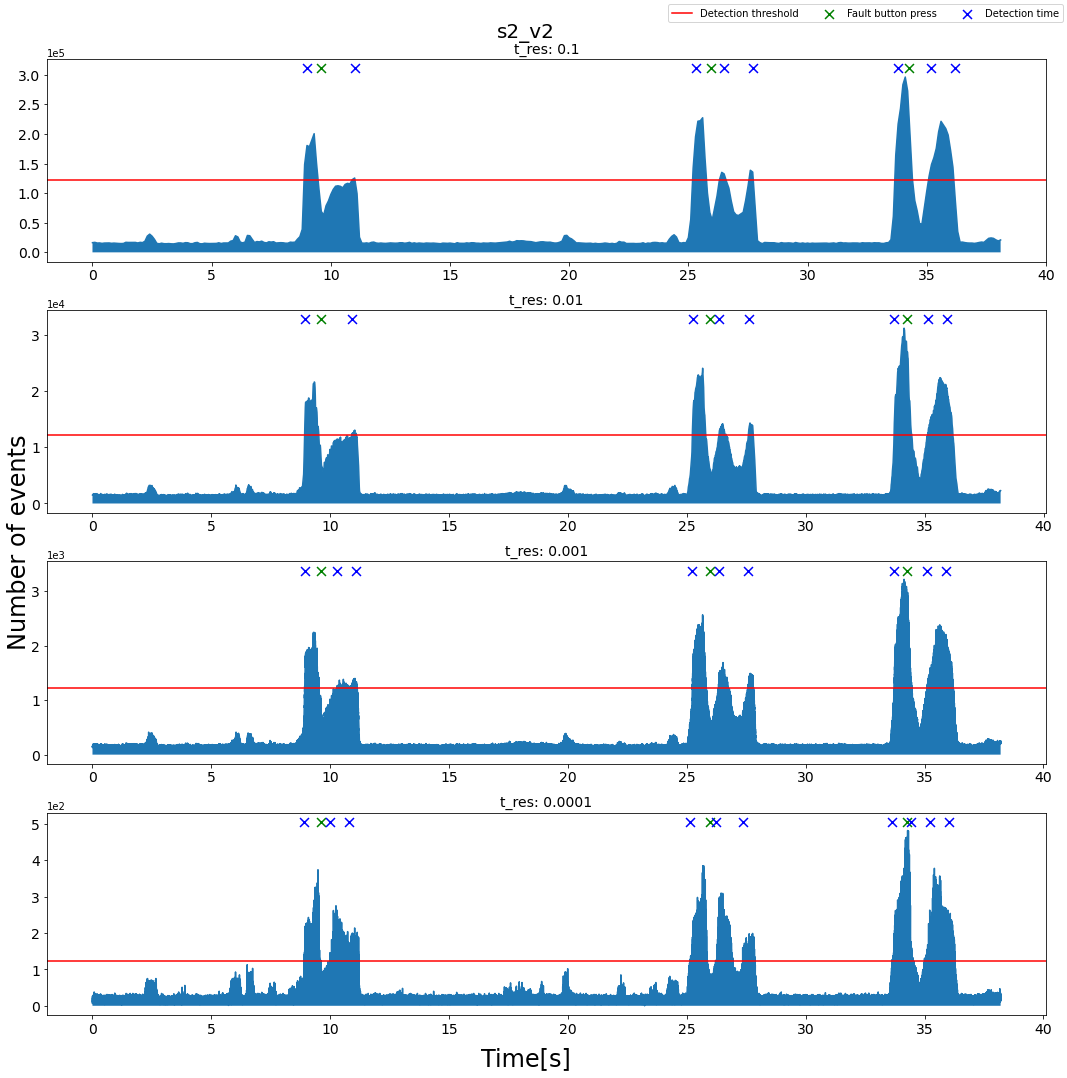

In [5]:
scale = 1.0
# dataset_tres_ls = [0.1, 0.01, 0.001, 0.0002, 0.0001]
dataset_tres_ls = [10**(-x) for x in np.linspace(1, 4, 4)]
base_thresh = 12
t_start = 0
t_end = np.inf
press_timing = press_timing[
    np.logical_and(press_timing[:, 0] > t_start,
                   press_timing[:, 0] < t_end) 
]

fig, axs = plt.subplots(len(dataset_tres_ls), 1, figsize=(15, 15))

mean_differences = []
n_detections = []

# scale controlls the radius scale
roi = utils.get_roi(roi_center, roi_edge, scale=scale)
roi[0] = np.clip(roi[0], 0, 640) # hardcoded img resolution
roi[1] = np.clip(roi[1], 0, 480)

ts_filt, window_size = utils.get_events_roi(events, roi)

for ax, dataset_tres in zip(axs, dataset_tres_ls):

    # plot the histogrm, it is faster to use line plot
    h, bins = utils.get_hist(ts_filt, dataset_tres, t_start=t_start, t_end=t_end)
    ax.plot(bins[:-1], h)
    ax.fill_between(bins[:-1], h)
    # get y val for markers to be on the top of the plot
    plt_y_lim = ax.get_ylim()
    v = plt_y_lim[1]

    # scale the threshold depending on the time resolution and roi dimension
    detection_thresh = utils.get_threshold(base_thresh, dataset_tres, window_size, scale)
    print(f"Detection threshold: {detection_thresh}")
    ax.axhline(y=detection_thresh, color='red', label="Detection threshold")


    ax.scatter(press_timing[:, 0], [v for x in press_timing[:, 0]], marker="x", c="green", label="Fault button press", s=80)
    detection_times = utils.get_detections(h, detection_thresh, bins, dataset_tres)
    ax.scatter(detection_times, [v for x in detection_times], marker="x", c="blue", label="Detection time", s=80)


    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.tick_params(labelsize=14)
    ax.set_title(f"t_res: {dataset_tres}", fontsize=14)

    differences = utils.measure_time_difference(detection_times, press_timing)
    mean_differences.append(np.mean(differences))
    n_detections.append(len(detection_times) - len(press_timing))

fig.suptitle(sequence_name, fontsize=20)
fig.supxlabel("Time[s]", fontsize=24)
fig.supylabel("Number of events", fontsize=24)

lines, labels = fig.axes[-1].get_legend_handles_labels()
plt.figlegend(lines,labels, ncol=3)

fig.tight_layout()


In [6]:
# dataset_tres_ls = [0.1, 0.01, 0.001, 0.0002, 0.0001]
dataset_tres_ls = [10**(-x) for x in np.linspace(1, 4, 20)]
t_start = 0
t_end = np.inf
press_timing = press_timing[
    np.logical_and(press_timing[:, 0] > t_start,
                   press_timing[:, 0] < t_end) 
]
mean_differences = []
n_detections = []

# scale controlls the radius scale
roi = utils.get_roi(roi_center, roi_edge, scale=scale)
roi[0] = np.clip(roi[0], 0, 640) # hardcoded img resolution
roi[1] = np.clip(roi[1], 0, 480)

ts_filt, window_size = utils.get_events_roi(events, roi)

for dataset_tres in tqdm(dataset_tres_ls):

    # measure the event rate
    h, bins = utils.get_hist(ts_filt, dataset_tres, t_start=t_start, t_end=t_end)

    # scale the threshold depending on the time resolution and roi dimension
    detection_thresh = utils.get_threshold(base_thresh, dataset_tres, window_size, scale)
    detection_times = utils.get_detections(h, detection_thresh, bins, dataset_tres)

    differences = utils.measure_time_difference(detection_times, press_timing)
    mean_differences.append(np.mean(differences))
    n_detections.append(len(detection_times) - len(press_timing))


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


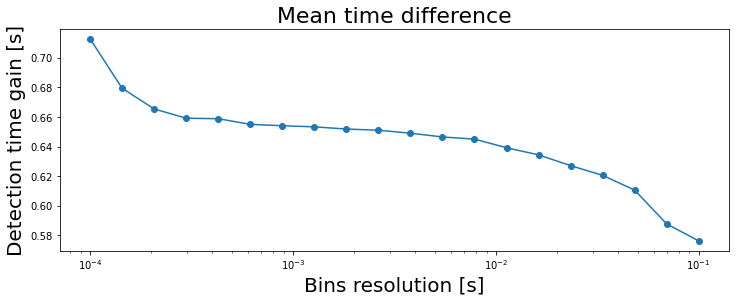

In [7]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(2, 1, 1)
ax.plot(dataset_tres_ls, mean_differences, marker="o")
ax.set_xticks(dataset_tres_ls)
ax.set_xscale('log')
ax.set_xlabel("Bins resolution [s]", fontsize=20)
ax.set_ylabel("Detection time gain [s]", fontsize=20)
ax.set_title("Mean time difference", fontsize=22);


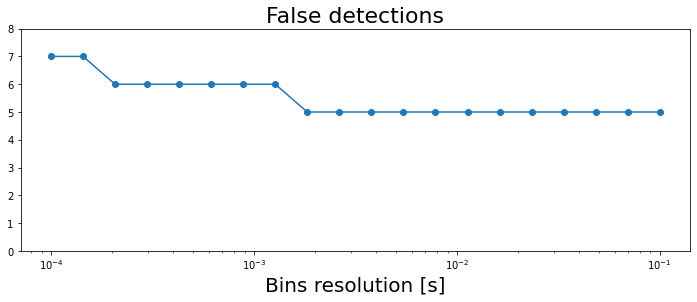

In [8]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(2, 1, 1)
ax.plot(dataset_tres_ls, n_detections, marker="o")
ax.set_xticks(dataset_tres_ls)
# ax.set_yticks(n_detections)
ax.set_ylim([0, max(n_detections) + 1])
ax.set_xscale('log')
ax.set_xlabel("Bins resolution [s]", fontsize=20)
# ax.set_ylabel("number of detections", fontsize=20)
ax.set_title("False detections", fontsize=22);


In [9]:
10e-3

0.01